In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [65]:
dfr=pd.read_csv('tempSiteRatings.csv')
dfd=pd.read_csv('tempUrlMetrics.csv')

In [66]:
#print(dfd['slno'].values==dfr['id'].values)
dfd['rating']=dfr['rating']
dfd.to_csv('dataReg.csv')

In [67]:
data=pd.read_csv('data.csv')
data.drop(['Unnamed: 0'],1, inplace=True)

In [68]:
def changeColName(data):
    try:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity','rating']
        data.columns=columns
    except:
        columns=['word_count','body_text_percent','emphasized_text_percent','text_position_changes','text_cluster_count','link_count','page_size','graphic_percent','graphic_count','colour_count','font_count','colourfulness','visual_complexity']
        data.columns=columns
    return data

In [69]:
def dropMetrics(data):
    try:
        data.drop(['id','url'],1, inplace=True)#,'p1','p2','p4','p6','p7','p10','p11','p12','p13'
    except:
        data.drop(['slno','url'],1, inplace=True)
    return data

In [70]:
def stdNormal(data,mean,std):
    x = data.values #returns a numpy array
    columns=data.columns
    x_scaled=(x-mean)/std
    data=pd.DataFrame(x_scaled,columns=columns)
    return data

In [71]:
def catCol(data,col):
    data[col+'_high']=np.zeros(data[col].shape)
    data[col+'_avg']=np.ones(data[col].shape)
    data[col+'_low']=np.zeros(data[col].shape)

    data[col+'_high'][np.where(data[col]>.431)[0]]=1.0
    data[col+'_avg'][np.where(data[col]>.431)[0]]=0.0
    data[col+'_avg'][np.where(data[col]<-.431)[0]]=0.0
    data[col+'_low'][np.where(data[col]<-.431)[0]]=1.0
    data.drop([col],1,inplace=True)
    return data

In [72]:
def catColPdf(data,col):
    import scipy.stats
    
    mean_high=np.mean(data[col][np.where(data[col]>.431)[0]])
    std_high=np.std(data[col][np.where(data[col]>.431)[0]])


    mean_avg=np.mean(data[col][np.where(abs(data[col])<.431)[0]])
    std_avg=np.std(data[col][np.where(abs(data[col])<.431)[0]])

    mean_low=np.mean(data[col][np.where(data[col]<-.431)[0]])
    std_low=np.std(data[col][np.where(data[col]<-.431)[0]])

    data[col+'_high']=scipy.stats.norm(mean_high,std_high).pdf(data[col].values)
    data[col+'_avg']=scipy.stats.norm(mean_avg,std_avg).pdf(data[col].values)
    data[col+'_low']=scipy.stats.norm(mean_low,std_low).pdf(data[col].values)
    
    data.drop([col],1,inplace=True)
    
    return data


In [73]:
def preProcess(data,mean,std):
    data=changeColName(data)
    try:
        rating=data['rating']
        data.drop(['rating'],1,inplace=True)
    except:
        pass
    data=stdNormal(data,mean,std)
    data=catCol(data,'word_count')
    data=catCol(data,'page_size') 
    data=catCol(data,'colourfulness') 
    data=catCol(data,'visual_complexity') 
    try:
        data['rating']=rating
    except:
        pass
    return data

In [74]:
data=dropMetrics(data)

In [75]:
mean=np.mean(data.values[:,:-1],axis=0)
std=np.std(data.values[:,:-1],axis=0)


In [76]:
data=preProcess(data,mean,std)
irrCol=['emphasized_text_percent','font_count']
data.drop(irrCol,1,inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [77]:
correlation = data.corr(method='pearson')
columns = correlation.nlargest(30,'rating').index
np.sort(columns)

array(['body_text_percent', 'colour_count', 'colourfulness_avg',
       'colourfulness_high', 'colourfulness_low', 'graphic_count',
       'graphic_percent', 'link_count', 'page_size_avg', 'page_size_high',
       'page_size_low', 'rating', 'text_cluster_count',
       'text_position_changes', 'visual_complexity_avg',
       'visual_complexity_high', 'visual_complexity_low',
       'word_count_avg', 'word_count_high', 'word_count_low'],
      dtype=object)

In [78]:
columns=columns.tolist()
columns=pd.Index(columns)

In [79]:
Y=data['rating'].values
X_temp=data[columns]
X_temp.drop(['rating'],1, inplace=True)
X=X_temp.values

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [80]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True,test_size=0.3, random_state=1)

In [136]:
def LinearReg():
    from sklearn.linear_model import LinearRegression
    reg =LinearRegression(normalize=True)
    return reg
def RidgeReg():
    from sklearn.linear_model import Ridge
    reg =Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=1, solver='svd', tol=0.001)
    return reg
def MLPReg():
    from sklearn.neural_network import MLPRegressor
    reg=MLPRegressor(hidden_layer_sizes=(60,),activation='logistic',solver='adam', max_iter=10000,batch_size=10,alpha=0.001)
    return reg
def KNNReg():
    from sklearn.neighbors import KNeighborsRegressor
    clf=KNeighborsRegressor(n_neighbors=4)
    return clf
def RMS_test(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_test)
    return Y_pred,mean_squared_error(Y_test, Y_pred)
def RMS_train(reg):
    from sklearn.metrics import mean_squared_error
    Y_pred=reg.predict(X_train)
    return Y_pred,mean_squared_error(Y_train, Y_pred)


In [137]:
regLinear=KNNReg()
regLinear.fit(X_train,Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [138]:
RMS_test(regLinear)[1],RMS_train(regLinear)[1]

(0.8976525500063072, 0.5145106811871777)

In [139]:
Y_pred=RMS_test(regLinear)[0]
rsq=np.sum((Y_pred-np.mean(Y_pred))**2)/np.sum((Y_test-np.mean(Y_test))**2)
rsq

0.3054654465879736

In [140]:
N,p=X.shape
adjRsq=1-((1-rsq)*(N-1)/(N-p-1))
adjRsq

0.1271390071983992

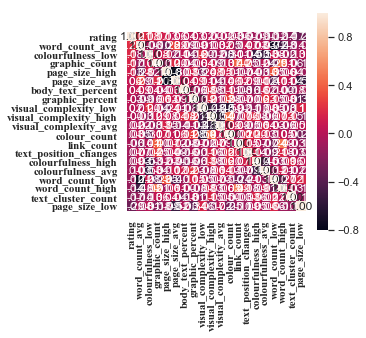

In [141]:
fig, ax = plt.subplots(figsize=(4,4))    
correlation_map = np.corrcoef(data[columns].values.T)
sns.set(font_scale=1)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f',yticklabels=columns.values, xticklabels=columns.values)
#plt.savefig('corr.png')
#plt.show()


In [142]:
import random
tupleSig=[]

for i in zip(columns[1:],regLinear.coef_):
    tupleSig.append(i)
tupleSig.append(('font_count',(random.random()+1)/1000))
tupleSig.append(('emphasized_text_percent',(random.random()+1)/1000))
tupleSig.sort()
for tup in tupleSig:
    print(tup[0].capitalize().replace('_',' '),'&',round(tup[1],5),'\\\\')


AttributeError: 'KNeighborsRegressor' object has no attribute 'coef_'

In [143]:
(0.5698664373765342, 0.6068637013770535) 


(0.5698664373765342, 0.6068637013770535)

In [144]:
testDiff=RMS_test(regLinear)[0]-Y_test
trainDiff=RMS_train(regLinear)[0]-Y_train
trainDiff,testDiff,(np.where(abs(testDiff)>1)[0].shape,testDiff.shape),(np.where(abs(trainDiff)>1)[0].shape,trainDiff.shape)

(array([-1.60416667, -0.57291667, -0.12550725, -0.08197464,  0.28304348,
         0.58458333,  0.20958333,  0.18583333,  0.23137681, -0.57246377,
         0.01041667,  0.59875   ,  0.13677536, -0.43027174, -0.72282609,
         0.43478261,  1.70695652,  0.68472826, -1.00949275,  2.17389493,
        -0.05842391,  1.35550725,  0.03847826, -0.02083333,  0.45471014,
         1.15804348, -0.79438406,  0.15217391,  0.82155797,  0.76630435,
        -0.29664855, -0.44791667,  0.59648551, -0.37318841, -0.57791667,
        -0.35869565,  0.76347826,  0.8129529 ,  0.29936594, -0.54541667,
        -0.58333333,  0.60009058,  0.61674736,  0.70380435,  0.39507246,
        -0.44610507, -0.09561594,  0.11684783, -0.44958333, -0.79851449,
         0.29302536, -0.0925    ,  0.29771739,  0.49094203, -1.08559783,
        -0.15217391, -0.44842391, -0.39432971,  1.30887681,  0.11007246,
        -1.37681159, -0.95012681,  0.12681159,  1.31431159,  0.09375   ]),
 array([-0.80842391,  0.55615942,  0.66293478, -0

In [145]:
df={}
irrCol=['emphasized_text_percent','font_count']
for year in range(2000,2020):
    df[str(year)]=pd.read_csv('yearMetrics/tempMpUrlMetrics'+str(year)+'.csv')
    df[str(year)]=dropMetrics(df[str(year)])
    df[str(year)]=preProcess(df[str(year)],mean,std)
    df[str(year)].drop(irrCol,1,inplace=True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [146]:
columns[1:]

Index(['word_count_avg', 'colourfulness_low', 'graphic_count',
       'page_size_high', 'page_size_avg', 'body_text_percent',
       'graphic_percent', 'visual_complexity_low', 'visual_complexity_high',
       'visual_complexity_avg', 'colour_count', 'link_count',
       'text_position_changes', 'colourfulness_high', 'colourfulness_avg',
       'word_count_low', 'word_count_high', 'text_cluster_count',
       'page_size_low'],
      dtype='object')

In [147]:
meanYears=np.zeros(20)
stdYears=np.zeros(20)
for year in range(2000,2020):
    #try:
        meanYears[year-2000]=np.mean(regLinear.predict(df[str(year)][columns[1:]].values))
        stdYears[year-2000]=np.std(regLinear.predict(df[str(year)][columns[1:]].values))
    #except:
    #    print(year)

In [148]:
meanYears,stdYears

(array([3.99468429, 3.96753546, 3.95828649, 4.05950907, 4.03116229,
        4.05145043, 4.08826589, 4.25517581, 4.26723195, 4.34475065,
        4.3649531 , 4.44614462, 4.46217304, 4.50048557, 4.47614104,
        4.45756308, 4.46327676, 4.49875668, 4.50876281, 4.49423674]),
 array([0.46679082, 0.49653578, 0.46219821, 0.50483022, 0.47060585,
        0.46263916, 0.45271976, 0.42041723, 0.448581  , 0.41491307,
        0.43500341, 0.40091286, 0.4107528 , 0.36886591, 0.38719335,
        0.39790366, 0.41240491, 0.41680024, 0.41502049, 0.42442219]))

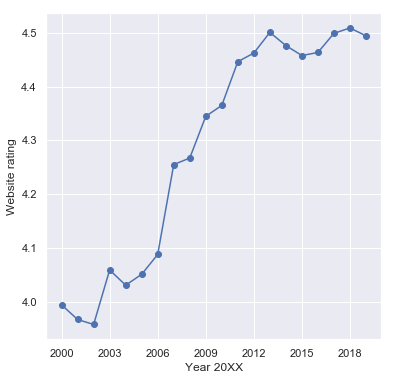

In [149]:
fig, ax = plt.subplots(figsize=(6,6))
x=range(2000,2020)
y=meanYears
e=stdYears*0
plt.errorbar(x, y, e, fmt='-o')
plt.xticks(np.arange(min(x), max(x)+1, 3))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 50
plt.ylabel('Website rating')
plt.xlabel('Year 20XX')
plt.savefig('modelRegKNN')

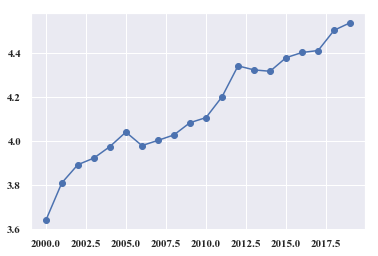

In [110]:
x=range(2000,2020)
y=meanYears
e=stdYears*0
plt.errorbar(x, y, e, fmt='-o')
plt.savefig('linearReg')